In [1]:
import glob
import os

In [2]:
def findFiles(path):return glob.glob(path)

PATH = "data_rnn/data/names/"
#print(findFiles(f"{PATH}/*.txt"))
print(findFiles(PATH+"*.txt"))

['data_rnn/data/names\\Arabic.txt', 'data_rnn/data/names\\Chinese.txt', 'data_rnn/data/names\\Czech.txt', 'data_rnn/data/names\\Dutch.txt', 'data_rnn/data/names\\English.txt', 'data_rnn/data/names\\French.txt', 'data_rnn/data/names\\German.txt', 'data_rnn/data/names\\Greek.txt', 'data_rnn/data/names\\Irish.txt', 'data_rnn/data/names\\Italian.txt', 'data_rnn/data/names\\Japanese.txt', 'data_rnn/data/names\\Korean.txt', 'data_rnn/data/names\\Polish.txt', 'data_rnn/data/names\\Portuguese.txt', 'data_rnn/data/names\\Russian.txt', 'data_rnn/data/names\\Scottish.txt', 'data_rnn/data/names\\Spanish.txt', 'data_rnn/data/names\\Vietnamese.txt']


In [3]:
#open(f"{PATH}/Arabic.txt").read().strip().split("\n")[:10]
open(PATH+"Arabic.txt").read().strip().split("\n")[:5]

['Khoury', 'Nahas', 'Daher', 'Gerges', 'Nazari']

In [4]:
import string
import unicodedata

all_letters = string.ascii_letters + ".,;'"
n_letters = len(all_letters)
print(n_letters)

56


In [5]:
def unicodeToAscii(s):
    return "".join(c for c in unicodedata.normalize("NFD",s) if unicodedata.category(c) != 'Mn')
print(unicodeToAscii('Ślusàrski'))

Slusarski


In [6]:
category_lines = {}
all_categories = []

def readNames(filename):
    lines = open(filename, "r", encoding= 'utf-8').read().strip().split("\n")
    return [unicodeToAscii(line) for line in lines]

#for file in findFiles(f"{PATH}/*.TXT"):
for file in findFiles(PATH+"*.txt"):
    language = os.path.splitext(os.path.basename(file))[0]
    category_lines[language] = readNames(file)
    all_categories.append(language)
    
n_categories = len(all_categories)

In [7]:
#find number of languages, and names
for k,v in category_lines.items():
    print("{} has {} names".format(k, len(v)))

Spanish has 298 names
Czech has 519 names
Chinese has 268 names
Dutch has 297 names
French has 277 names
Arabic has 2000 names
Italian has 709 names
Greek has 203 names
Irish has 232 names
Scottish has 100 names
German has 724 names
English has 3668 names
Japanese has 991 names
Polish has 139 names
Korean has 94 names
Russian has 9408 names
Portuguese has 74 names
Vietnamese has 73 names


In [8]:
import torch

def letterToIndex(letter):
    return all_letters.find(letter)

def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

letterToTensor('J')

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])

In [9]:
def lineToTensor(line):
    one_hot_encode = torch.zeros(len(line), 1, n_letters)
    for idx, letter in enumerate(line):
        one_hot_encode[idx][0][letterToIndex(letter)] = 1
    return one_hot_encode

lineToTensor("xiao").size()

torch.Size([4, 1, 56])

In [10]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim = 1)
    
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [11]:
input = letterToTensor("A")
hidden = torch.zeros(1, n_hidden)
output, next_hidden = rnn(input, hidden)

In [12]:
input = lineToTensor("Albert")
hidden = torch.zeros(1, n_hidden)
output, next_hidden = rnn(input[0], hidden)
output

tensor([[-2.8848, -2.8572, -2.7823, -2.8247, -2.7892, -2.8751, -2.9003, -2.8558,
         -2.9428, -2.9329, -2.9777, -3.0063, -2.9813, -2.8885, -2.9862, -2.8244,
         -2.8379, -2.9191]], grad_fn=<LogSoftmaxBackward>)

In [13]:
def categoryFromOutput(output):
    #top_n is the logprobability, and top_i is the index
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

categoryFromOutput(output)

('Czech', 2)

In [14]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Polish / line = Filipowski
category = Polish / line = Dziedzic
category = French / line = Desjardins
category = Portuguese / line = Souza
category = Chinese / line = Tong
category = Irish / line = Ruadhain
category = Russian / line = Mischenkov
category = Russian / line = Gachegov
category = Czech / line = Grygarova
category = Spanish / line = Amador


In [18]:
import torch.optim as optim

learning_rate = 5e-3
criterion = nn.NLLLoss()
optimizer = optim.SGD(rnn.parameters(), lr = learning_rate, momentum = 0.9)

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    rnn.zero_grad()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
        loss = criterion(output, category_tensor)
        loss.backward(retain_graph=True)
        optimizer.step()
    return output, loss.item()

In [19]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s/60)
    s -= m *60
    return "{} {}".format(m,s)

In [20]:
from tqdm import tqdm

start = time.time()
for iter in tqdm(range(1, n_iters+1)):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))
    
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

  5%|███▋                                                                       | 4987/100000 [00:30<09:47, 161.79it/s]

5000 5% (0 30.912792205810547) nan Giolla / Vietnamese ✗ (Irish)


 10%|███████▍                                                                   | 9988/100000 [01:00<09:07, 164.29it/s]

10000 10% (1 0.8842747211456299) nan Rutkowski / Vietnamese ✗ (Polish)


 15%|███████████                                                               | 14989/100000 [01:32<08:42, 162.70it/s]

15000 15% (1 32.25523018836975) nan Rusnak / Vietnamese ✗ (Polish)


 20%|██████████████▊                                                           | 19994/100000 [02:03<08:14, 161.77it/s]

20000 20% (2 3.6531808376312256) nan Duncan / Vietnamese ✗ (Scottish)


 25%|██████████████████▍                                                       | 24993/100000 [02:39<07:57, 157.10it/s]

25000 25% (2 39.131646156311035) nan Groß / Vietnamese ✗ (German)


 30%|██████████████████████▏                                                   | 29999/100000 [03:12<07:28, 155.91it/s]

30000 30% (3 12.434974431991577) nan Romijnsen / Vietnamese ✗ (Dutch)


 35%|█████████████████████████▉                                                | 34994/100000 [03:45<06:59, 154.97it/s]

35000 35% (3 45.85188913345337) nan Hong / Vietnamese ✗ (Korean)


 40%|█████████████████████████████▌                                            | 39999/100000 [04:16<06:25, 155.76it/s]

40000 40% (4 16.818941593170166) nan Nowell / Vietnamese ✗ (English)


 45%|█████████████████████████████████▎                                        | 44983/100000 [04:46<05:50, 156.88it/s]

45000 45% (4 46.84324908256531) nan Yoshifumi / Vietnamese ✗ (Japanese)


 50%|████████████████████████████████████▉                                     | 49994/100000 [05:19<05:19, 156.49it/s]

50000 50% (5 19.526390075683594) nan Walentowicz / Vietnamese ✗ (Polish)


 55%|████████████████████████████████████████▋                                 | 54998/100000 [05:52<04:48, 156.16it/s]

55000 55% (5 52.19837141036987) nan Ochida / Vietnamese ✗ (Japanese)


 60%|████████████████████████████████████████████▍                             | 59986/100000 [06:24<04:16, 155.98it/s]

60000 60% (6 24.65396499633789) nan Toma / Vietnamese ✗ (Arabic)


 65%|████████████████████████████████████████████████                          | 64985/100000 [06:56<03:44, 155.87it/s]

65000 65% (6 57.00870132446289) nan Eagle / Vietnamese ✗ (English)


 70%|███████████████████████████████████████████████████▊                      | 69985/100000 [07:27<03:12, 156.26it/s]

70000 70% (7 27.977890491485596) nan Luong / Vietnamese ✓


 75%|███████████████████████████████████████████████████████▍                  | 74997/100000 [07:59<02:39, 156.48it/s]

75000 75% (7 59.28957152366638) nan Zou / Vietnamese ✗ (Chinese)


 80%|███████████████████████████████████████████████████████████▏              | 79999/100000 [08:30<02:07, 156.74it/s]

80000 80% (8 30.400533199310303) nan Peller / Vietnamese ✗ (Russian)


 85%|██████████████████████████████████████████████████████████████▉           | 84994/100000 [09:00<01:35, 157.32it/s]

85000 85% (9 0.29718661308288574) nan Chweh / Vietnamese ✗ (Korean)


 90%|██████████████████████████████████████████████████████████████████▌       | 89992/100000 [09:30<01:03, 157.70it/s]

90000 90% (9 30.697184801101685) nan Polites / Vietnamese ✗ (Greek)


 95%|██████████████████████████████████████████████████████████████████████▎   | 94993/100000 [10:01<00:31, 158.01it/s]

95000 95% (10 1.2177119255065918) nan Zaloumi / Vietnamese ✗ (Greek)


100%|█████████████████████████████████████████████████████████████████████████▉| 99996/100000 [10:30<00:00, 158.49it/s]

100000 100% (10 30.962689638137817) nan Zielinski / Vietnamese ✗ (Polish)


100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [10:30<00:00, 158.49it/s]


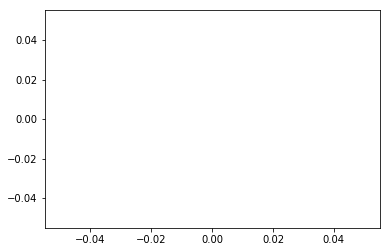

In [21]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.plot(all_losses)

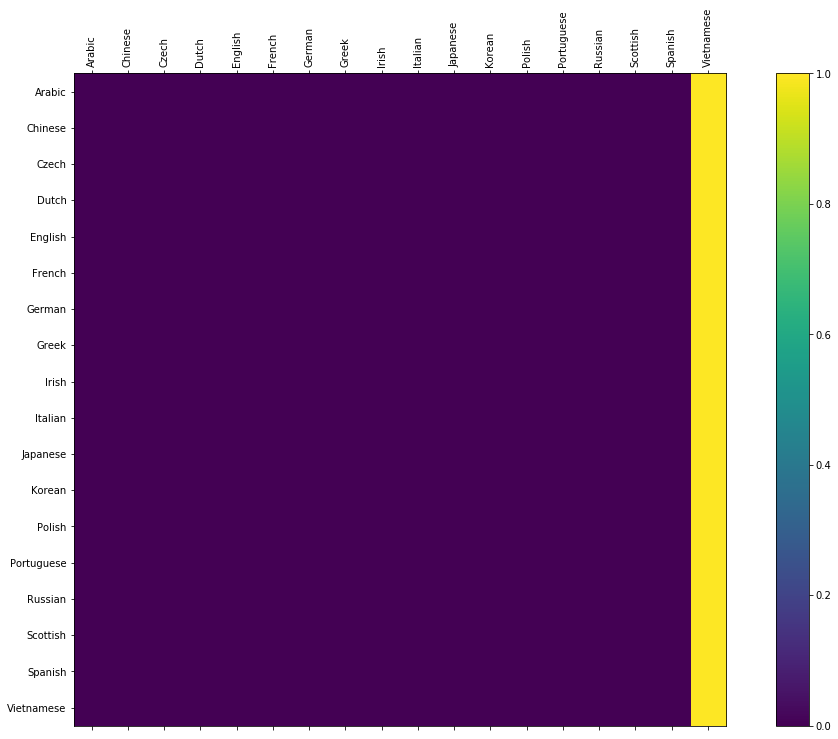

In [22]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure(figsize=(18,12))
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [23]:
def predict(input_line, n_predictions = 3):
    print("\n > {}".format(input_line))
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []
        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print("{:.2f} {}".format(value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

In [24]:
predict("Xiao")
predict("Jackson")
predict("Satoshi")


 > Xiao
nan German
nan Greek
nan Vietnamese

 > Jackson
nan German
nan Greek
nan Vietnamese

 > Satoshi
nan German
nan Greek
nan Vietnamese
